In [1]:
# Importing required libraries

# Library for data cleaning and data manipulation
import pandas as pd
import numpy as np

# Library for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
import geopandas as gpd

# Library for normality test
import scipy.stats as stats

In [2]:
# Load the Dataset
df = pd.read_csv(r"C:\Users\user\OneDrive\Documents\Airbnb-Listings-Bangkok-Project\data\cleaned\data_cleaned.csv")

# Drop unnecessary columns from the dataset
df.drop(columns=["id", "host_id"], inplace=True)

### **4.3. Evaluate Impact of Room Type and Minimum Stay Policy**

**Goals:**<br>
To understand how different room types and minimum stay policies influence the total number of bookings on Airbnb. By examining the relationship between these factors and booking volume, we can gain valuable insights into market trends and identify opportunities for optimization.

**Approach:**<br> I will use the Kruskal-Wallis test for non-parametric data to evaluate whether there are differences in the number of reviews between room types and minimum stay categories.

**Hypothesis Testing 1:** Testing the relationship between "**Number of Reviews**" and "**Room Type**"

- **H0** : There is no significant difference in the number of reviews based on room type categories.
- **H1** : There is a significant difference in the number of reviews based on room type categories.

In [3]:
# Group the data by 'room_type' and get the 'number_of_reviews' for each room type
grouped_data = df.groupby('room_type')['number_of_reviews'].apply(list)

# Perform Kruskal-Wallis test
kruskal_results = stats.kruskal(*grouped_data)

# Display results
print(f"Kruskal-Wallis H-statistic: {kruskal_results.statistic}")
print(f"Kruskal-Wallis p-value: {kruskal_results.pvalue}")

# Interpret the results
if kruskal_results.pvalue > 0.05:
    print(f"p-value = {kruskal_results.pvalue} > 0.05. Fail to reject H₀. No significant difference in number of reviews by room type.")
else:
    print(f"p-value = {kruskal_results.pvalue} <= 0.05. Reject H₀. Significant difference in number of reviews by room type.")

Kruskal-Wallis H-statistic: 1435.7011606372444
Kruskal-Wallis p-value: 5.2750721588747e-311
p-value = 5.2750721588747e-311 <= 0.05. Reject H₀. Significant difference in number of reviews by room type.


**Conclusion:**<br>
I have enough evidence to conclude that the number of reviews based on room type categories in Bangkok is significantly different. This means that this '**room type**' is effective in increasing '**number of reviews**' at the airbnb listings Bangkok.

**Hypothesis Testing 2 :** Testing the relationship between "**Number of Reviews**" and "**Minimum Nights**"

- **H0** : There is no significant difference in the number of reviews based on minimum night categories.
- **H1** : There is a significant difference in the number of reviews based on minimum night categories.

In [4]:
# Create categories for 'minimum_nights'
df['minimal_nights_category'] = pd.cut(df['minimum_nights'], 
                                       bins=[1, 5, 10, 20, 40, float('inf')],
                                       labels=["1-5 nights", "6-10 nights", "11-20 nights", "21-40 nights", "40+ nights"])

# Group the data by 'minimal_nights_category' and get the 'number_of_reviews' for each group
grouped_data = df.groupby('minimal_nights_category', observed=True)['number_of_reviews'].apply(list)

# Perform Kruskal-Wallis test
kruskal_results = stats.kruskal(*grouped_data)

# Display results
print(f"Kruskal-Wallis H-statistic: {kruskal_results.statistic}")
print(f"Kruskal-Wallis p-value: {kruskal_results.pvalue}")

# Step 4: Interpret the results
if kruskal_results.pvalue > 0.05:
    print(f"p-value = {kruskal_results.pvalue} > 0.05. Fail to reject H₀. No significant difference in number of reviews.")
else:
    print(f"p-value = {kruskal_results.pvalue} <= 0.05. Reject H₀. Significant difference in number of reviews.")

Kruskal-Wallis H-statistic: 310.33538128187865
Kruskal-Wallis p-value: 6.384389477002338e-66
p-value = 6.384389477002338e-66 <= 0.05. Reject H₀. Significant difference in number of reviews.


**Conclusion:**<br>
I have enough evidence to conclude that the number of reviews based on minimum night categories in Bangkok is significantly different. This means that this '**minimum nights**' is effective in increasing '**number of reviews**' at the airbnb listings Bangkok.

**Analysis Proccess**

In [5]:
# Grouping Minimum Nights into bins
bins = [1, 5, 10, 20, 40, df['minimum_nights'].max()]
labels = ["1-5 nights", "6-10 nights", "11-20 nights", "21-40 nights", "40+ nights"]
df["minimal_nights_group"] = pd.cut(df["minimum_nights"], bins=bins, labels=labels, right=False)

# Analyzing the impact of grouped minimum nights on price, reviews, and availability
minimal_nights_analysis = df.groupby("minimal_nights_group", observed=True).agg(
    average_price=("price", "mean"),
    total_reviews=("number_of_reviews", "sum"),
    avg_availability=("availability_365", "mean")
).reset_index()

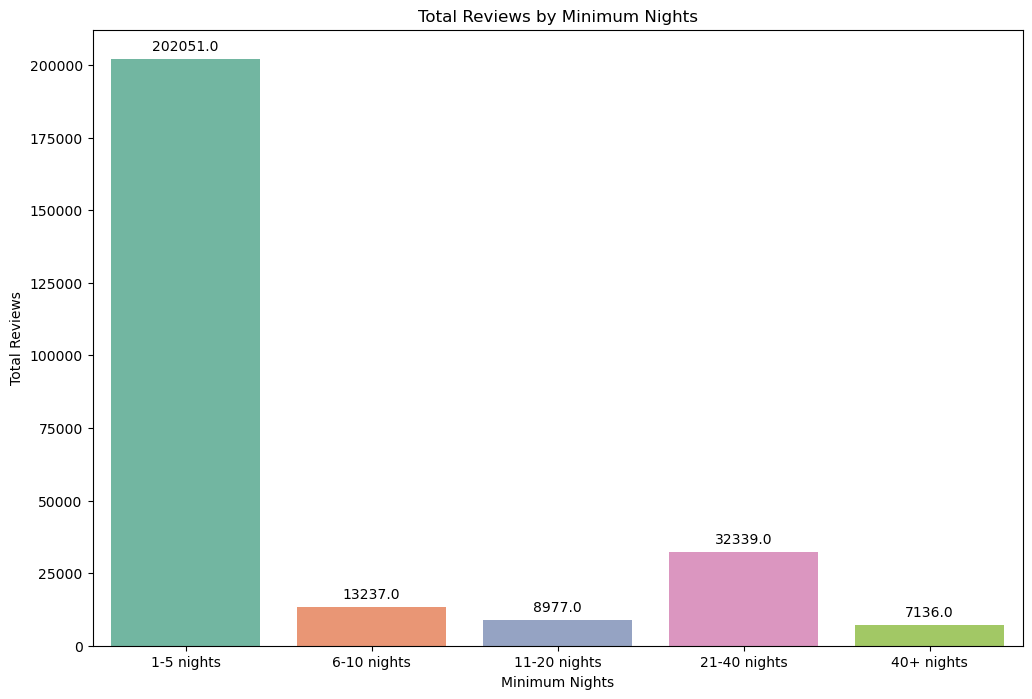

In [6]:
# Average Price by Minimum Nights
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=minimal_nights_analysis, x="minimal_nights_group", y="total_reviews", 
                 hue="minimal_nights_group", legend=False, palette="Set2")

for p in ax.patches:
    ax.annotate(format(p.get_height()),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', 
                xytext = (0, 9),
                textcoords = 'offset points')

plt.title("Total Reviews by Minimum Nights")
plt.xlabel("Minimum Nights")
plt.ylabel("Total Reviews")
plt.show()

**Insight:**
- **1-5 Nights** is significantly taller than the others, indicating that the majority of reviews come from short-term stays. This suggests a **strong preference for shorter durations** among Airbnb users.

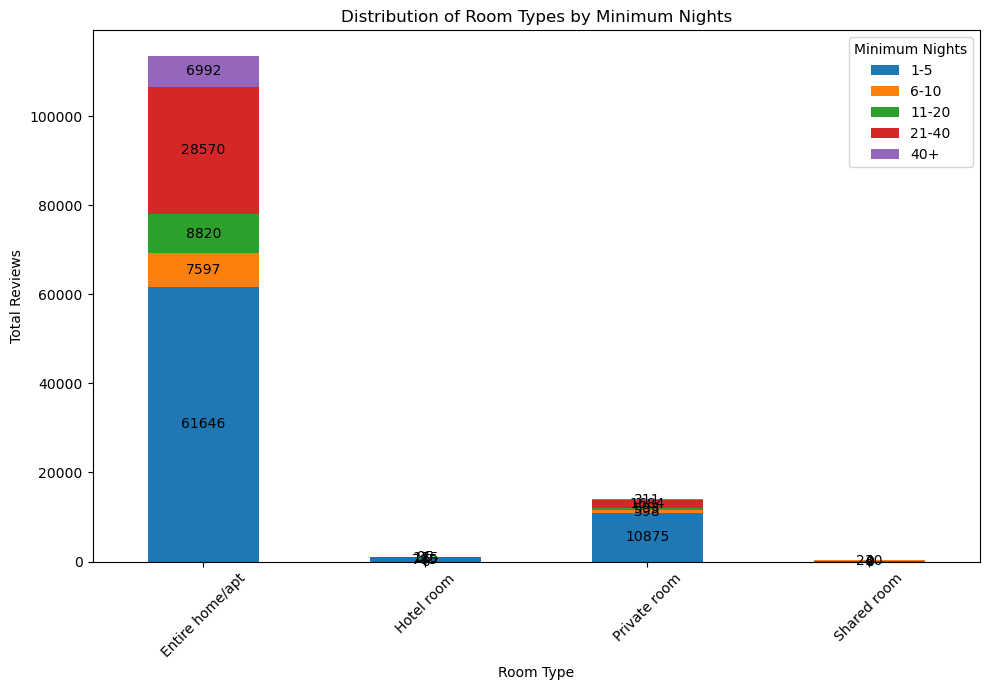

In [7]:
# Ensure 'minimum_nights' is numeric
df['minimum_nights'] = pd.to_numeric(df['minimum_nights'], errors='coerce') 

# Now, group data by 'room_type' and categorized 'minimum_nights'
grouped_data = df.groupby([
    'room_type', 
    pd.cut(df['minimum_nights'], bins=[1, 5, 10, 20, 40, np.inf], labels=["1-5", "6-10", "11-20", "21-40", "40+"])
], observed=True).agg({'number_of_reviews': 'sum'})

# Reset index for plotting
grouped_data = grouped_data.reset_index()

# Pivot the table to make 'room_type' columns for stacked bar plot
pivot_data = grouped_data.pivot(index='room_type', columns='minimum_nights', values='number_of_reviews')

# Create a stacked bar plot
ax = pivot_data.plot(kind='bar', stacked=True, figsize=(10, 7))

# Add numeric labels on the bars
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.0f}', (x + width / 2, y + height / 2), ha='center', va='center')

# Formatting the plot
plt.title('Distribution of Room Types by Minimum Nights')
plt.xlabel('Room Type')
plt.ylabel('Total Reviews')
plt.xticks(rotation=45)
plt.legend(title='Minimum Nights', bbox_to_anchor=(1, 1))
plt.tight_layout()  # To ensure the plot doesn't get cut off

# Display the plot
plt.show()

**Insight:**
1. ***Dominance of Entire Homes/Apartments:***<br> The "Entire home/apt" category has the highest number of listings across all minimum night ranges. This suggests that **entire home/apat are the most popular type** of accommodation on Airbnb, particularly for longer stays.

2. ***Minimum Night Preferences:*** 
    - The 1-5 nights category dominates the distribution for all room types. This suggests a high demand for short-term stays, likely driven by tourists and leisure travelers.
    - As the minimum night requirement increases, the number of listings generally decreases. This suggests that longer-term stays are less common.